In [1]:
%pip install wasserstein umap-learn ipython ipywidgets --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn import metrics

In [3]:
import creating.pendulum as pend
import creating.harmonic_oscillator as ho
import creating.kepler_problem as kp
import creating.double_pendulum as dp
import creating.coupled_oscillator as co

In [4]:
%mkdir -p trajectories/coupled_oscillator
%mkdir -p trajectories/double_pendulum
%mkdir -p trajectories/harmonic_oscillator
%mkdir -p trajectories/pendulum
%mkdir -p trajectories/kepler_problem
%mkdir -p trajectories/three_body_problem

ЋиЁЎЄ  ў бЁ­в ЄбЁбҐ Є®¬ ­¤л.
ЋиЁЎЄ  ў бЁ­в ЄбЁбҐ Є®¬ ­¤л.
ЋиЁЎЄ  ў бЁ­в ЄбЁбҐ Є®¬ ­¤л.
ЋиЁЎЄ  ў бЁ­в ЄбЁбҐ Є®¬ ­¤л.
ЋиЁЎЄ  ў бЁ­в ЄбЁбҐ Є®¬ ­¤л.
ЋиЁЎЄ  ў бЁ­в ЄбЁбҐ Є®¬ ­¤л.


In [5]:
pend.create_trajectories(5)
ho.create_trajectories(5)
kp.create_trajectories(5)
dp.create_trajectories(5)
co.create_trajectories(5)

100%|██████████| 5/5 [00:01<00:00,  4.58it/s]
5it [00:00, ?it/s]


(array([[[ 9.04668658e-01,  8.88819192e-02, -5.71865291e-02,
           5.57950811e-03],
         [ 8.97807785e-01,  8.84867457e-02, -8.62557861e-02,
           1.54233447e-02],
         [ 8.78706062e-01,  9.96215010e-02, -2.19801226e-01,
           3.44127162e-02],
         ...,
         [-8.59505036e-02,  7.20087208e-01,  3.00552575e-01,
           4.65931126e-01],
         [-5.86960637e-02,  7.65196397e-01,  3.47748531e-01,
           3.30568587e-01],
         [-9.91407226e-03,  7.90697446e-01,  3.90556252e-01,
           2.23047079e-01]],
 
        [[ 8.31959990e-01,  2.35906716e-01, -2.42563464e-01,
          -6.15876737e-04],
         [ 8.03640597e-01,  2.41929302e-01, -3.48583093e-01,
          -2.24536254e-03],
         [ 7.06008645e-01,  2.78812934e-01, -4.99082540e-01,
          -8.13090462e-03],
         ...,
         [ 1.12102249e-01,  7.52359561e-01,  3.96929818e-01,
           2.72824001e-01],
         [ 1.30661298e-01,  7.59990404e-01,  4.04041793e-01,
           2.35933

In [6]:
import utils

In [7]:
class AE(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, intermediate_dim: int):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, intermediate_dim),
            nn.Tanh(),
            nn.Linear(intermediate_dim, hidden_dim),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, intermediate_dim),
            nn.Tanh(),
            nn.Linear(intermediate_dim, input_dim),
            nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
def rand_point(dim=3):
    x = np.random.rand(dim)
    x[0] *= np.random.choice([-1, 1])
    x[1] *= np.random.choice([-1, 1])
    return x / np.linalg.norm(x)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu" # cpu is faster ??

In [10]:
def train_model(traj, hidden_layer_dim, epochs=1000, intermediate_dim=10, batch_size=64):
    input_dim = traj.shape[1]

    model = AE(input_dim, hidden_layer_dim, intermediate_dim).to(device)
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters())
    # traj_microbatches = np.split(traj, traj.shape[0] / microbatch_size)
    # traj_microbatches = np.array([x.flatten() for x in traj_microbatches])
    dataloader = DataLoader(traj, batch_size=batch_size, shuffle=True)
    epoch_loss = []
    for epoch in tqdm(range(epochs)):
        running_loss = 0
        for batch_pts in dataloader:
            optimizer.zero_grad()
            inp = batch_pts.float().to(device)
            output = model(inp)
            loss = criterion(output, inp)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
        epoch_loss.append(running_loss)
    return model, epoch_loss

In [11]:
def full_train(traj, max_hidden_size, epochs=1000, intermediate_dim=10, batch_size=64):
    models = []
    epoch_losses_k = []

    for hidden_layer_size in tqdm(range(1, max_hidden_size + 1)):
        model, epoch_losses = train_model(traj, hidden_layer_size, intermediate_dim=intermediate_dim, batch_size=batch_size, epochs=epochs)
        epoch_losses_k.append(epoch_losses)
        models.append(model)
    return models, epoch_losses_k

In [31]:
decision_threshold = 0.06

In [32]:
def plot_losses(experiment_name, n_eff, epoch_losses_k, max_hidden_size):
    plt.scatter(range(1, max_hidden_size + 1), np.array(epoch_losses_k)[:,-1], c=[1 if x < n_eff else 0 for x in range(1, max_hidden_size + 1)])
    plt.axhline(y=decision_threshold, color='blue', linestyle='--')
    plt.title(f"{experiment_name}. n_eff={n_eff}")
    plt.xlabel("hidden layer size")
    plt.ylabel("MSE loss after AE")
    plt.show()

    plotted_loss = epoch_losses_k[n_eff - 1]
    plt.plot(range(len(plotted_loss)), plotted_loss)
    plt.title(f"{experiment_name}. model with {n_eff} hidden dim")
    plt.xlabel("iteration")
    plt.ylabel("MSE")
    plt.show()

## 5-dimensional sphere (example)

In [34]:
experiment_name = "sphere5"
traj_s5 = np.array([rand_point(dim=5) for x in range(1000)])
print(traj_s5.shape)
n_eff = 4 # ground truth
max_hidden_size = 6
epochs = 5000

(1000, 5)


In [14]:
models_s5, epochs_s5 = full_train(traj_s5, max_hidden_size, epochs=epochs)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

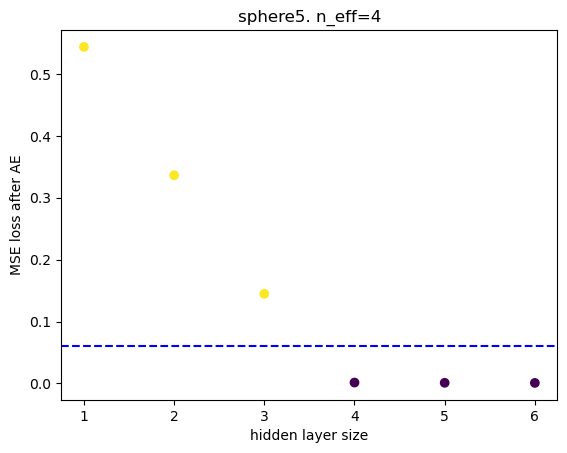

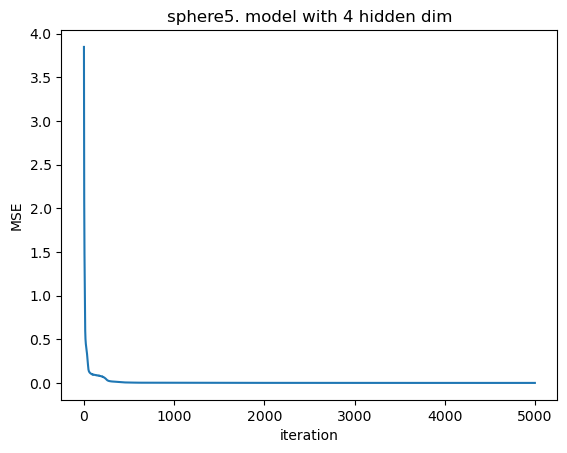

In [35]:
plot_losses(experiment_name, n_eff, epochs_s5, max_hidden_size)

## Pendulum

In [36]:
experiment_name = "pendulum"
traj_p = utils.get_data(experiment_name, count=1, sample_size=1000)[0]
print(traj_p.shape)
n_eff = 1 # ground truth
max_hidden_size = 4
epochs = 5000

(1000, 2)


In [17]:
models_p, epochs_p = full_train(traj_p, max_hidden_size, epochs=epochs)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

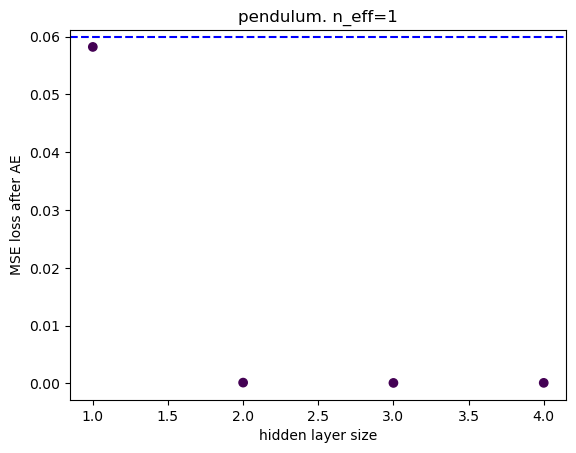

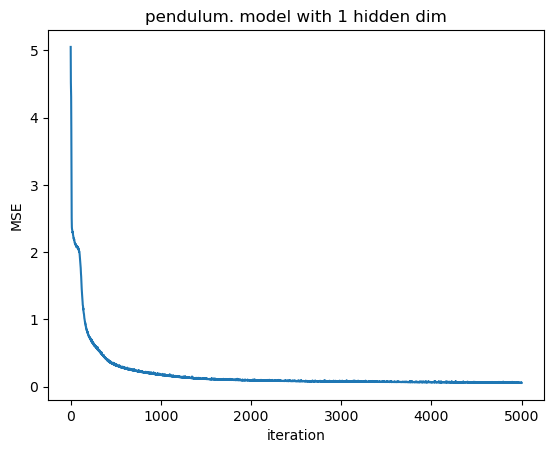

In [37]:
plot_losses(experiment_name, n_eff, epochs_p, max_hidden_size)

## Harmonic oscillator

In [38]:
experiment_name = "harmonic_oscillator"
traj_h = utils.get_data(experiment_name, count=1, sample_size=1000)[0]
print(traj_h.shape)
n_eff = 1 # ground truth
max_hidden_size = 4
epochs = 5000

(1000, 2)


In [20]:
models_h, epochs_h = full_train(traj_h, max_hidden_size, epochs=epochs)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

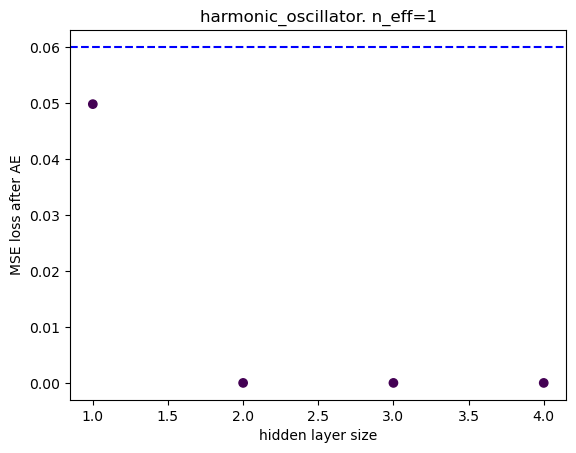

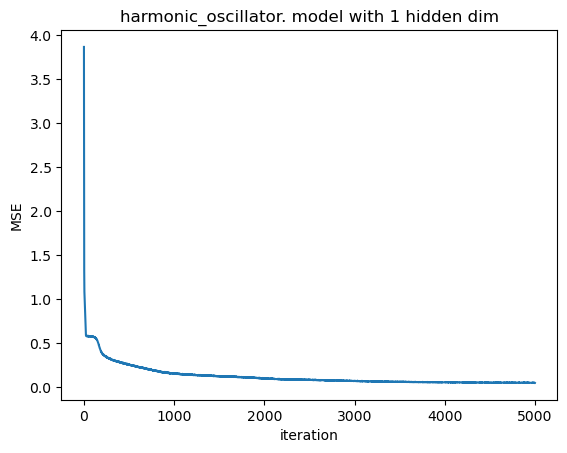

In [39]:
plot_losses(experiment_name, n_eff, epochs_h, max_hidden_size)

## Double pendulum

In [40]:
experiment_name = "double_pendulum"
traj_dp = utils.get_data(experiment_name, count=1, sample_size=1000)[0]
print(traj_dp.shape)
n_eff = 3 # ground truth
max_hidden_size = 7
epochs = 5000

(1000, 4)


In [23]:
models_dp, epochs_dp = full_train(traj_dp, max_hidden_size, epochs=epochs)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

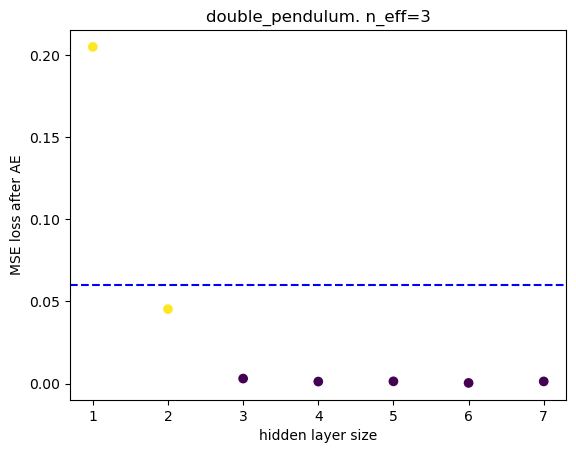

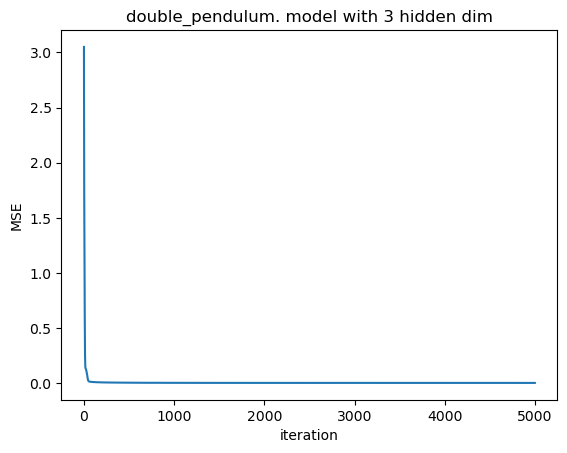

In [41]:
plot_losses(experiment_name, n_eff, epochs_dp, max_hidden_size)

## Coupled oscillator

In [42]:
experiment_name = "coupled_oscillator"
traj_co = utils.get_data(experiment_name, count=1, sample_size=1000)[0]
print(traj_co.shape)
n_eff = 2 # ground truth
max_hidden_size = 6
epochs = 5000

(1000, 4)


In [26]:
models_co, epochs_co = full_train(traj_co, max_hidden_size, epochs=epochs)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

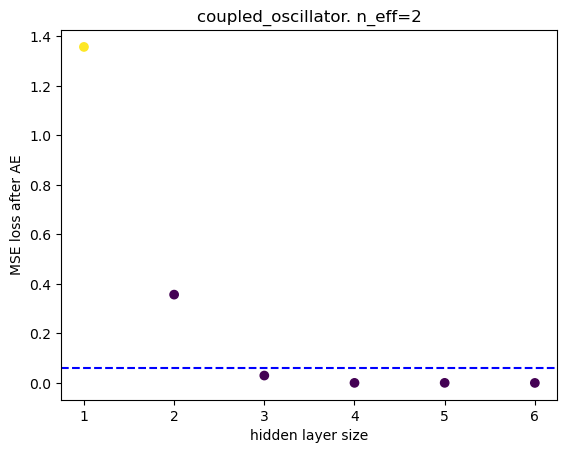

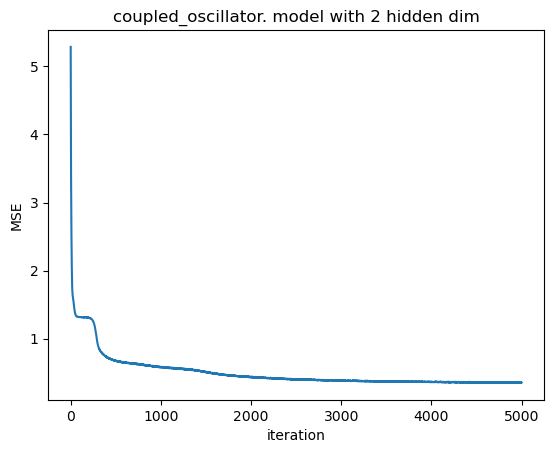

In [43]:
plot_losses(experiment_name, n_eff, epochs_co, max_hidden_size)

## Kepler problem

In [44]:
experiment_name = "kepler_problem"
traj_kp = utils.get_data(experiment_name, count=1, sample_size=1000)[0]
print(traj_kp.shape)
n_eff = 1 # ground truth
max_hidden_size = 6
epochs = 5000

(1000, 4)


In [29]:
models_kp, epochs_kp = full_train(traj_co, max_hidden_size, epochs=epochs)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

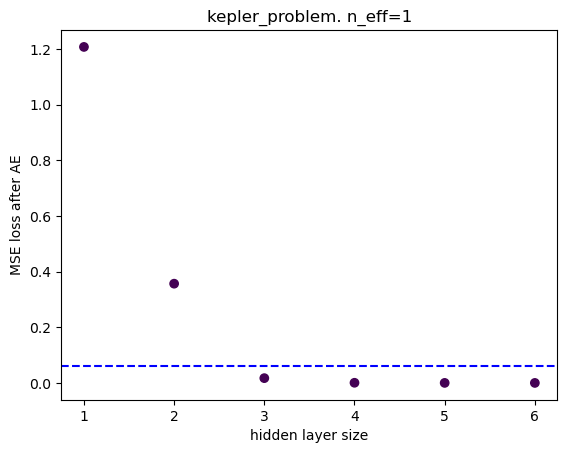

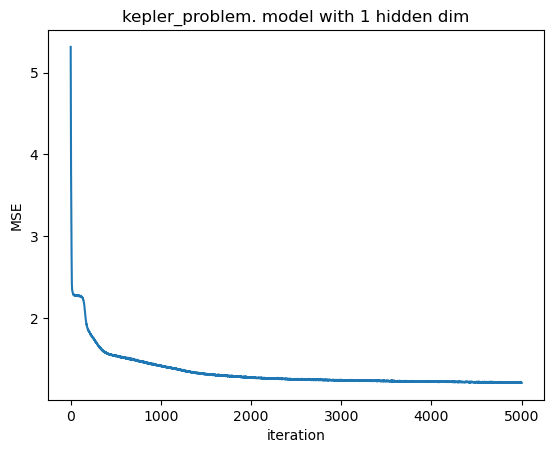

In [45]:
plot_losses(experiment_name, n_eff, epochs_kp, max_hidden_size)